# Daily Sunshine App NLP Model

## Objective of this Notebook
To create a NLP Model that classifies a given piece of plaintext into two categories, Good or Bad. The output of the model will be presented as a floating point numeral. This numeral will help us interpret the decision.

## Notebook Plan

- Multiple models will be created for each of the following datasets as training input
  - [IMDb Movie Reviews Dataset](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)
  - [Financial Phrase Bank Dataset](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news)
  - [Positive and Negative Word List](https://www.kaggle.com/datasets/mukulkirti/positive-and-negative-word-listrar)
  - [News Sentiment Dataset](https://www.kaggle.com/datasets/hoshi7/news-sentiment-dataset)

- All the above models will be tested on 
  - New Data points from the newsapi.org API
  - ["All the News" Dataset](https://www.kaggle.com/datasets/snapcrack/all-the-news)
  - ["Million News Headlines" Dataset](https://www.kaggle.com/datasets/therohk/million-headlines)
  

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.12.*"
!pip install -q tf-models-official==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 22.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 23.8 MB/s eta 0:00:00


In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

## Evaluation Datasets

### "All the News" Dataset

In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/all_the_news.csv" "/content/all_the_news.csv"

In [5]:
atn_dataframe = pd.read_csv('all_the_news.csv', encoding = 'utf-8', encoding_errors = 'ignore')

In [6]:
atn_dataframe.drop(atn_dataframe.iloc[:, 3:], inplace=True, axis=1)
atn_dataframe.drop(atn_dataframe.iloc[:, :2], inplace=True, axis=1)
atn_dataframe

,title
0,House Republicans Fret About Winning Their Hea...
1,Rift Between Officers and Residents as Killing...
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi..."
4,Kim Jong-un Says North Korea Is Preparing to T...
...,...
49995,"Rex Tillerson Says Climate Change Is Real, but …"
49996,The Biggest Intelligence Questions Raised by t...
49997,Trump Announces Plan That Does Little to Resol...
49998,Dozens of For-Profit Colleges Could Soon Close


In [7]:
def atn_array(n = 10):
  return np.squeeze(atn_dataframe.sample(n=n).values)

In [8]:
atn_array(20)

array(['Oklahoma congressman: It’s ’bull crap’ that constituents pay my salary ',
       'Trump Campaign Manager Reveals Fox News Debate Chief Has Daughter Working for Rubio',
       'Hillary: ‘I Don’t Pay Attention to the Polling When It’s Good or Bad’ - Breitbart',
       'Chris Rock Rewriting Show in Wake of Oscars Diversity Controversy - Breitbart',
       'Joe Biden on 2016: ‘I’ve Learned Never to Say No’ - Breitbart',
       'Beware the political rise of the world’s tech titans',
       'Koch Brothers Network Ready to Oppose Trump - Breitbart',
       'What tests you really need (and when)',
       'Heckler Taunts Bill Clinton: ’You’re a Rapist!’ - Breitbart',
       'Hillary Clinton Deleted More Emails Than She Sent to the State Department - Breitbart',
       'Bloomberg’s Ramesh Ponnuru: Immigration Is the New Litmus Test for GOP - Breitbart',
       'Donald Trump on Terror: ‘This Bloodshed Must End’',
       'Roger Goodell Banks $34.1 in Annual Salary in Most Recent Tax Filing

### Million News Headlines Dataset

In [9]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/million_news_headlines.csv" "/content/million_news_headlines.csv"

In [10]:
mnh_dataframe = pd.read_csv('million_news_headlines.csv', encoding = 'utf-8', encoding_errors = 'ignore')
mnh_dataframe

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [11]:
mnh_dataframe.drop(mnh_dataframe.iloc[:, 0:1], inplace=True, axis=1)
mnh_dataframe

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers
...,...
1244179,two aged care residents die as state records 2...
1244180,victoria records 5;919 new cases and seven deaths
1244181,wa delays adopting new close contact definition
1244182,western ringtail possums found badly dehydrate...


In [12]:
def mnh_array(n = 10):
  return np.squeeze(mnh_dataframe.sample(n=n).values)

In [13]:
mnh_array(20)

array(['police investigate tamworth restaurant explosion',
       'joe biden says he doesnt regret his decision to withdraw troops',
       'patient rights violated by qeii smoking ban helen morton says',
       'police warn drivers to stay safe during holidays',
       'asbestos dumped in barunga nt sparks health concerns',
       'afl player manager ricky nixon speaking about ben',
       'rural qld charles agforce 0301',
       'there is one way to put a stop to bhp tax avoidance',
       'wales makes changes to face all blacks',
       'cba dividend payment sends market lower',
       'deny power privatisation call govt told',
       'family first promises 4000 a year for childcare',
       'nsw coronavirus seven new cases record testing numbers',
       'blues coach is a stand alone role',
       'managing love and relationships in coronavirus lockdown',
       'tensions ease after willowra accident police',
       'chief commissioner of vic police say crowds theyre for cowards',


## Model I - IMDb Movie Review Dataset

### Downloading the Dataset

In [14]:
imdb_url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

imdb_dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', imdb_url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

imdb_dataset_dir = os.path.join(os.path.dirname(imdb_dataset), 'aclImdb')

imdb_train_dir = os.path.join(imdb_dataset_dir, 'train')

84125825/84125825 [==============================] - 9s 0us/step


In [15]:
# Remove unused folders to make it easier to load the data
imdb_remove_dir = os.path.join(imdb_train_dir, 'unsup')
shutil.rmtree(imdb_remove_dir)

### Split the Data into Training, Testing & Validation sets

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

imdb_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

imdb_class_names = imdb_raw_train_ds.class_names
imdb_train_ds = imdb_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

imdb_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

imdb_val_ds = imdb_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

imdb_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

imdb_test_ds = imdb_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Visualise the data

In [17]:
for text_batch, label_batch in imdb_train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({imdb_class_names[label]})\n')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as the

### Selecting a Model

In [18]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocessing Model

In [19]:
imdb_bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

### Using the BERT Model

In [20]:
imdb_bert_model = hub.KerasLayer(tfhub_handle_encoder)

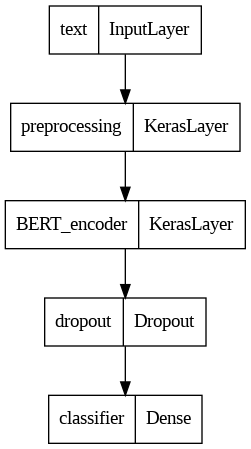

In [21]:
imdb_classifier_model = build_classifier_model()
tf.keras.utils.plot_model(imdb_classifier_model)

In [22]:
imdb_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
imdb_metrics = tf.metrics.BinaryAccuracy()

imdb_epochs = 5
imdb_steps_per_epoch = tf.data.experimental.cardinality(imdb_train_ds).numpy()
imdb_num_train_steps = imdb_steps_per_epoch * imdb_epochs
imdb_num_warmup_steps = int(0.1*imdb_num_train_steps)

imdb_init_lr = 3e-5
imdb_optimizer = optimization.create_optimizer(init_lr=imdb_init_lr,
                                          num_train_steps=imdb_num_train_steps,
                                          num_warmup_steps=imdb_num_warmup_steps,
                                          optimizer_type='adamw')

In [23]:
imdb_classifier_model.compile(optimizer=imdb_optimizer,
                         loss=imdb_loss,
                         metrics=imdb_metrics)

imdb_history = imdb_classifier_model.fit(x=imdb_train_ds,
                               validation_data=imdb_val_ds,
                               epochs=imdb_epochs)

Epoch 1/5
625/625 [==============================] - 194s 280ms/step - loss: 0.4945 - binary_accuracy: 0.7376 - val_loss: 0.3887 - val_binary_accuracy: 0.8330
Epoch 2/5
625/625 [==============================] - 172s 275ms/step - loss: 0.3306 - binary_accuracy: 0.8551 - val_loss: 0.3783 - val_binary_accuracy: 0.8490
Epoch 3/5
625/625 [==============================] - 172s 275ms/step - loss: 0.2564 - binary_accuracy: 0.8939 - val_loss: 0.3954 - val_binary_accuracy: 0.8496
Epoch 4/5
625/625 [==============================] - 172s 276ms/step - loss: 0.1999 - binary_accuracy: 0.9221 - val_loss: 0.4418 - val_binary_accuracy: 0.8512
Epoch 5/5
625/625 [==============================] - 174s 279ms/step - loss: 0.1545 - binary_accuracy: 0.9420 - val_loss: 0.4742 - val_binary_accuracy: 0.8502


### Evaluating the Model

In [24]:
imdb_loss, imdb_accuracy = imdb_classifier_model.evaluate(imdb_test_ds)

print(f'Loss: {imdb_loss}')
print(f'Accuracy: {imdb_accuracy}')

782/782 [==============================] - 100s 128ms/step - loss: 0.4546 - binary_accuracy: 0.8560
Loss: 0.45456168055534363
Accuracy: 0.8560000061988831


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

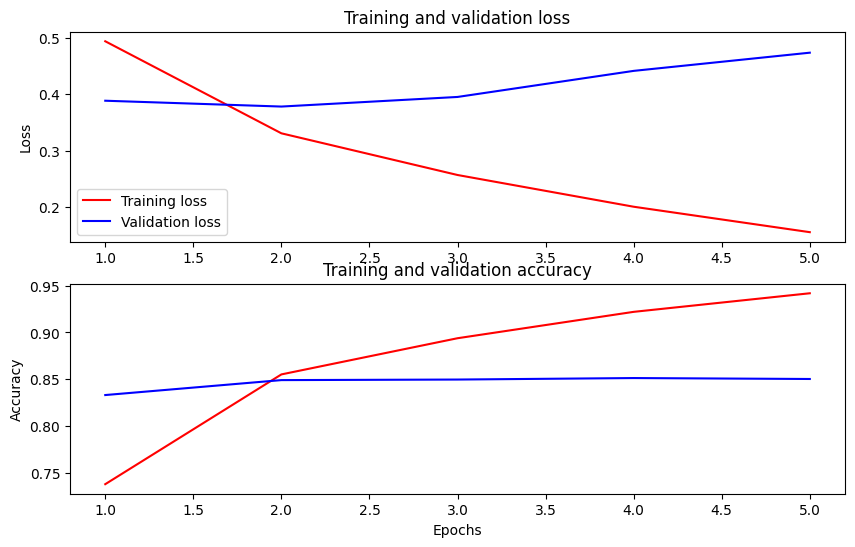

In [25]:
imdb_history_dict = imdb_history.history
print(imdb_history_dict.keys())

imdb_acc = imdb_history_dict['binary_accuracy']
imdb_val_acc = imdb_history_dict['val_binary_accuracy']
imdb_loss = imdb_history_dict['loss']
imdb_val_loss = imdb_history_dict['val_loss']

imdb_epochs = range(1, len(imdb_acc) + 1)
imdb_fig = plt.figure(figsize=(10, 6))
imdb_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(imdb_epochs, imdb_loss, 'r', label='Training loss')

plt.plot(imdb_epochs, imdb_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(imdb_epochs, imdb_acc, 'r', label='Training acc')
plt.plot(imdb_epochs, imdb_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [35]:
imdb_eval_data = np.concatenate([atn_array(30), mnh_array(30)], 0)
imdb_df = pd.DataFrame(np.squeeze(imdb_classifier_model.predict(imdb_eval_data)))
imdb_df.insert(1, "Title", imdb_eval_data, True)
imdb_df

2/2 [==============================] - 0s 144ms/step


,0,Title
0,-0.712771,Clarion: Syrian Christian Militia Condemns Tur...
1,3.916051,Talking About Sex and ‘The Affair’ With Domini...
2,0.864842,Canada Reports Four Zika Cases
3,2.518041,ESPN Gives Tim Tebow a Contract Extension - Br...
4,-2.655725,Environmental groups accuse Trump of ’head-fak...
5,5.267457,Covering up for World Hijab Day
6,0.984423,Dennis Prager to #NeverTrump: President Hillar...
7,-1.567004,Peter Hitchens: Scientific Consensus Leaves Pe...
8,-0.007090,HHS Report: Average Health Insurance Premiums ...
9,3.012134,‘He Used Us as Props’: Conservative Hispanics ...
